# Triangulation of M5.2 Kon Tum 28/07/2024 earthquake

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/tsonpham/ObsSeisHUS2025/blob/master/Day2/D2_Prac.ipynb)

Prepared by Thanh-Son Pham (thanhson.pham@anu.edu.au), April 2025.

---
## What we do in this note book

Here we learn one of the most fundamental skill in observational seismology, triangulating earthquakes using P- and S-wave arrivals.

Lets start with the fact-sheet and answer some questions,
- https://www.iris.edu/hq/inclass/fact-sheet/how_are_earthquakes_located

More information can be in the official websites,
- https://www.iris.edu/hq/inclass/lesson/locating_an_earthquake_with_recent_seismic_data
- https://www.iris.edu/hq/inclass/software-web-app/earthquake_triangulation

In [ ]:
# set up colab environment - uncomment the next line if running in colab

!pip install basemap obspy basemap-data-hires cartopy

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/56.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/56.0 kB ? eta -:--:--
     --------------------- ------------------ 30.7/56.0 kB 1.3 MB/s eta 0:00:01
     ---------------------------------- --- 51.2/56.0 kB 525.1 kB/s eta 0:00:01
     -------------------------------------- 56.0/56.0 kB 486.5 kB/s eta 0:00:00
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     -------------------- ------------------- 30.7/61.0 kB ? eta -:--:--
     -------------------------------------- 61.0/61.0 kB 651.3 kB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 3.2 MB/s eta 0:00:00
  Using cached charset_normalizer-3.4.1-cp312-cp312-win_amd64.whl.metadata (36 kB)
   ---


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#@title Run to set up retina display

%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

---
## Data preparation
Lets start by fetching the metadata of the M5.2 Kon Tum 28/07/2024 earthquake from the ISC catalog.

Because the event is large enought, the event's location and time are reported by several earthquake data acencies including the Intitutue of Geophysics, Vietnam Academy of Science and Technology. Smaller earthquakes in the region are only processed and reported by the VAST IGP (see Module 1's in-class exercise).

The ISC catalog are often reported by regional agencies and release the comprehensive catalog of global seismicity to the public. The ISC reviewed signficant events using their protocols and publish REVIEWED solutions often about with 2 years delay.

In [4]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# Initialize the client for ISC
isc = Client("ISC")

# Request event information
event = isc.get_events(eventid="641665444")[0]

# Print the event information
print(event)

Event:	2024-07-28T04:35:13.660000Z | +14.780, +108.173 | 5.54 mB

	            resource_id: ResourceIdentifier(id="smi:ISC/evid=641665444")
	             event_type: 'earthquake'
	   event_type_certainty: 'known'
	          creation_info: CreationInfo(agency_id='ISC', author='ISC')
	    preferred_origin_id: ResourceIdentifier(id="smi:ISC/origid=636774696")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:ISC/magid=644867575")
	                   ---------
	     event_descriptions: 1 Elements
	               comments: 1 Elements
	                origins: 1 Elements
	             magnitudes: 4 Elements


We use the origin time to download waveform data to demonstrate the concepts of earthquake triangulation. Data are downloaded using the [`obspy mass_downloader`](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html) tool. This tool is very helpful to explore the availability of seismic waveforms in a unfamiliar region without much local knowledge of the local seismic infrastructure. We will learn more about accessing seismic data later in this lecture series.

In [5]:
## download all available data using mass_downloader
from obspy.clients.fdsn.mass_downloader import CircularDomain, Restrictions, MassDownloader
from pathlib import Path

# Get the origin time, latitude, and longitude of the Kon Tum event
origin_time = event.preferred_origin().time
origin_lat = event.preferred_origin().latitude
origin_lon = event.preferred_origin().longitude

# Circular domain around the epicenter. This will download all data between
# 70 and 90 degrees distance from the epicenter. This module also offers
# rectangular and global domains. More complex domains can be defined by
# inheriting from the Domain class.
domain = CircularDomain(origin_lat, origin_lon, minradius=0.0, maxradius=15.0)

restrictions = Restrictions(
    # Get data from 5 minutes before the event to one hour after the
    # event. This defines the temporal bounds of the waveform data.
    starttime=origin_time - 1 * 60,
    endtime=origin_time + 10 * 60,
    # You might not want to deal with gaps in the data. If this setting is
    # True, any trace with a gap/overlap will be discarded.
    reject_channels_with_gaps=True,
    # And you might only want waveforms that have data for at least 95 % of
    # the requested time span. Any trace that is shorter than 95 % of the
    # desired total duration will be discarded.
    minimum_length=0.95,
    # No two stations should be closer than 10 km to each other. This is
    # useful to for example filter out stations that are part of different
    # networks but at the same physical station. Settings this option to
    # zero or None will disable that filtering.
    minimum_interstation_distance_in_m=150E3,
    # Only HH or BH channels. If a station has HH channels, those will be
    # downloaded, otherwise the BH. Nothing will be downloaded if it has
    # neither. You can add more/less patterns if you like.
    channel_priorities=["BH[ZNE12XY]", "HH[ZNE]"],
    # Location codes are arbitrary and there is no rule as to which
    # location is best. Same logic as for the previous setting.
    location_priorities=["", "00", "10"])

# No specified providers will result in all known ones being queried.
mdl = MassDownloader(providers=['IRIS'])
# The data will be downloaded to the ``./waveforms/`` and ``./stations/``
# folders with automatically chosen file names.
if not (Path("waveforms").exists() and Path("stations").exists()):
    mdl.download(domain, restrictions, mseed_storage="waveforms",
                stationxml_storage="stations")

[2025-04-23 14:59:39,340] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2025-04-23 14:59:41,127] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2025-04-23 14:59:41,130] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2025-04-23 14:59:41,130] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2025-04-23 14:59:43,619] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (2.49 seconds)
[2025-04-23 14:59:43,642] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 37 stations (111 channels).
[2025-04-23 14:59:43,647] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 27 stations.
[2025-04-23 14:59:43,652] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 81 time intervals/channels before downloading: NEE

In practice, we do not know the existence of the seismic event in advance, the event might be reported by locals or detected by an earthquake detection method. After detection, refining the event location is the second step to build an earthquake catalog.

Now, let's read the station metadata and plot their local map using the built-in plotting routine.

C:\Users\doy27\AppData\Roaming\Python\Python312\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\doy27\AppData\Roaming\Python\Python312\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\doy27\AppData\Roaming\Python\Python312\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\doy27\AppData\Roaming\Python\Python312\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)

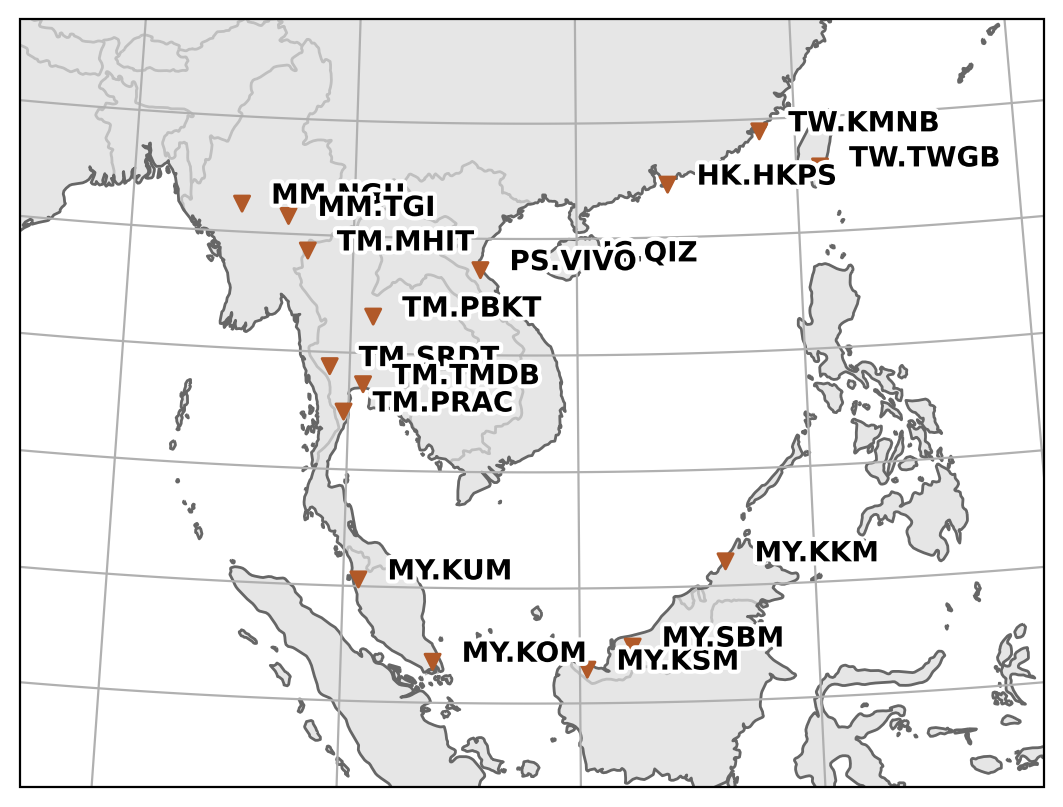

In [6]:
# read station metadata
from obspy import read_inventory, Inventory
import matplotlib.pyplot as plt

inv = Inventory()
for file in Path("stations").glob("*.xml"):
    inv += read_inventory(str(file))

inv.plot(projection='local', show=True, size=30, resolution='i')
plt.show()

Here we practise the mapping skill learned in Day 1 to plot the station map at the regional scale.

<>:35: SyntaxWarning: invalid escape sequence '\c'
<>:35: SyntaxWarning: invalid escape sequence '\c'
C:\Users\doy27\AppData\Local\Temp\ipykernel_18740\3293687890.py:35: SyntaxWarning: invalid escape sequence '\c'
  plt.clabel(mapple, inline=True, fmt='%1.0f$^\circ$', colors='black', use_clabeltext=True)


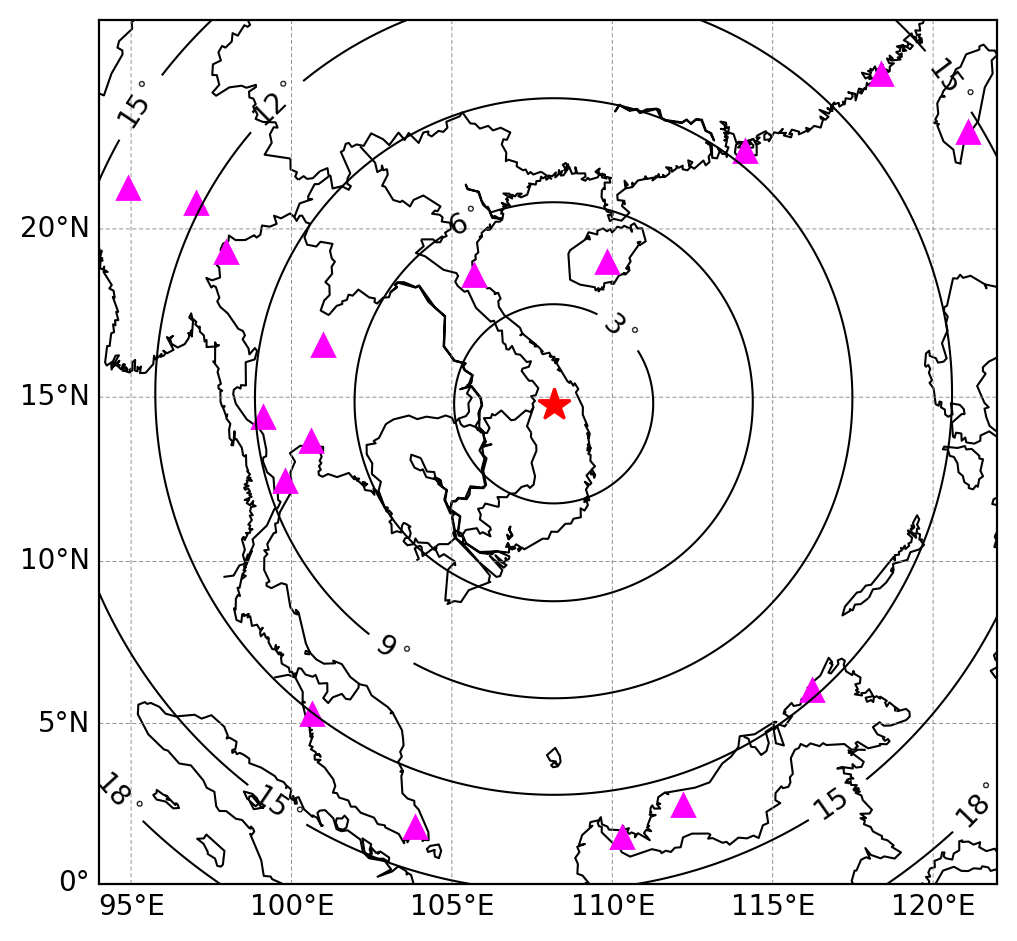

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

# create a new figure and axis
fig, ax = plt.subplots()
# initialize the basemap, specifing the projection, the gegraphic buondary, and resolution
# the initialzed map instance is attached to the axis ax
m = Basemap(projection='merc',ax=ax, llcrnrlat=0, urcrnrlat=26, llcrnrlon=94, urcrnrlon=122, resolution='l')
# draw coastlines
m.drawcoastlines(linewidth=0.75)
# draw country boundaries
m.drawcountries(linewidth=0.75)
# draw parallels and meridians
m.drawparallels(range(0, 25, 5), labels=[1,0,0,0], linewidth=0.3, color='gray', dashes=(5, 3))
m.drawmeridians(range(90, 125, 5), labels=[0,0,0,1], linewidth=0.3, color='gray', dashes=(5, 3))

# plot the epicenter
m.plot(origin_lon, origin_lat, 'r*', markersize=12, label='Epicenter', latlon=True)

# plot the station locations
for network in inv:
    for station in network:
        lon = station.longitude
        lat = station.latitude
        m.plot(lon, lat, '^', c='magenta', markersize=8, latlon=True)

# plot distance contours to the epicenter
from obspy.geodetics import locations2degrees
x = np.linspace(m.xmin, m.xmax, 300)
y = np.linspace(m.ymin, m.ymax, 300)
mlon, mlat = m(*np.meshgrid(x, y), inverse=True)
dist = locations2degrees(origin_lat, origin_lon, mlat, mlon)
mapple = m.contour(mlon, mlat, dist, levels=range(0, 19, 3), latlon=True, colors='k', linewidths=0.75)
plt.clabel(mapple, inline=True, fmt='%1.0f$^\circ$', colors='black', use_clabeltext=True)

# # add a colorbar
# plt.colorbar(mapple, label='Distance to epicenter [°]')

# show the plot
plt.tight_layout()
plt.show()

---
## Waveform processing and section plot

Lets read in waveform data as `obspy Stream` and high-pass filter the raw waveforms. In seismology, [Butterworth](https://en.wikipedia.org/wiki/Butterworth_filter) filter are widely used, often by default, in many seismological applications.

Please see much greater details on [filtering](https://seismo-live.github.io/html/Signal%20Processing/filter_basics_solution_wrapper.html) from this notebook. Note that we set `zerophase=False` here when interesting in the arrival time. After reading the cited notebook on seismogram filtering, could you explain why?

In [8]:
from obspy import read, Stream

# read the waveform data from the downloaded files
dstream = Stream()
for file in Path("waveforms").glob("*.mseed"):
    dstream += read(str(file))

# # select only the Z component for each station
# dstream = dstream.select(component='Z')

# remove instrument response
dstream.remove_response(inventory=inv, output='VEL')

# trim the data to the time window of interest
dstream.filter('highpass', freq=0.1, corners=2, zerophase=False)
dstream = dstream.trim(starttime=origin_time, endtime=origin_time + 600)
# append the distance in meters to the trace stats
for tr in dstream:
    tmp = inv.select(station=tr.stats.station, network=tr.stats.network)
    stla = tmp[0][0].latitude
    stlo = tmp[0][0].longitude
    tr.data /= np.max(np.abs(tr.data))
    tr.stats.update({'distance':locations2degrees(origin_lat, origin_lon, stla, stlo)*111.1195e3,
                     'stla':stla, 'stlo':stlo})

Real seismograms often contain with electrical glitches, gaps, or abnormal recordings. One often needs to be mindful about data quality control when dealing with real data.

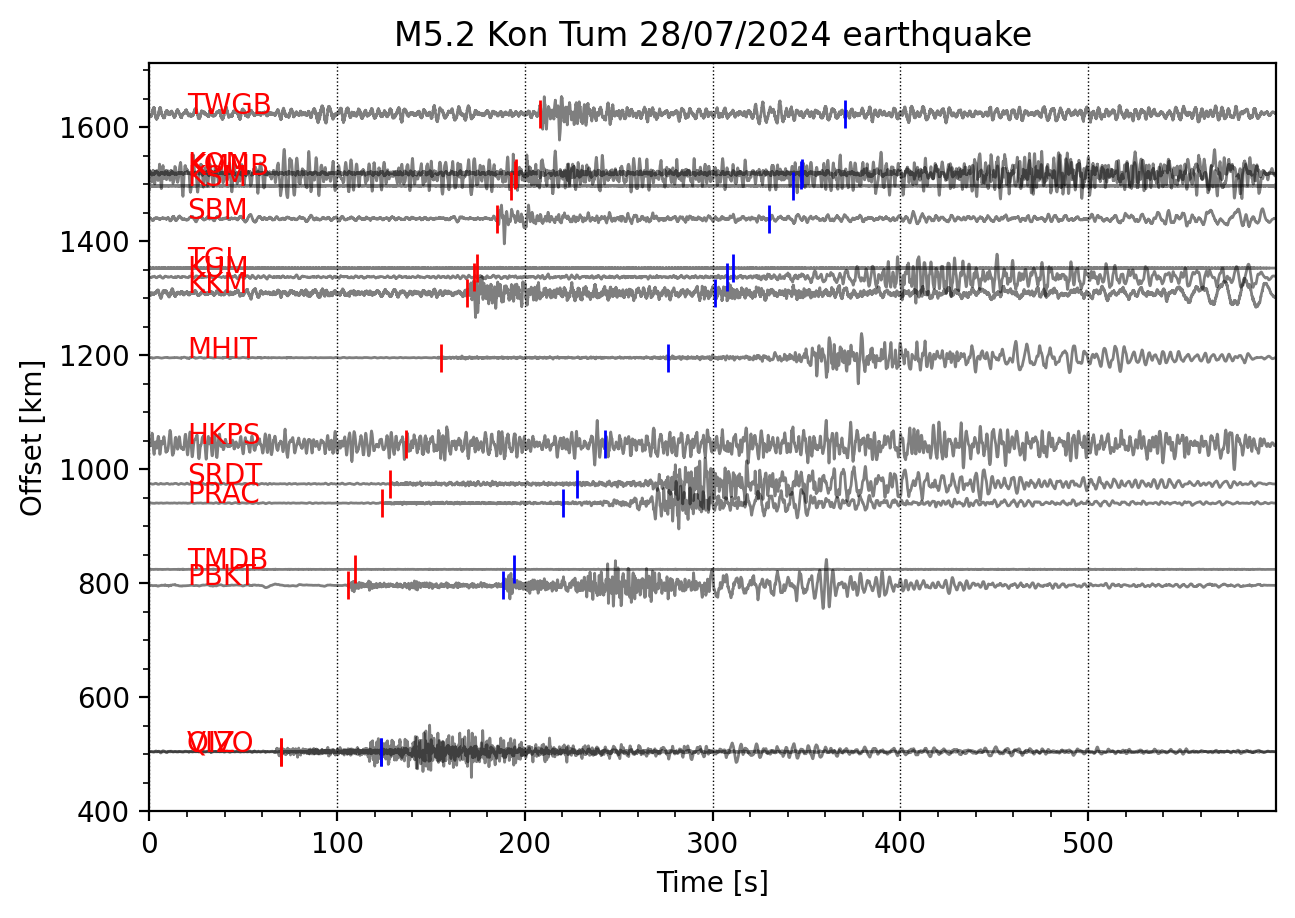

In [9]:
from obspy.taup import TauPyModel
taup_model = TauPyModel(model="ak135")

## plot stream waveform data using the build-in plotting function
fig = plt.figure()
dstream.select(component='Z').plot(type='section', orientation='horizontal', norm_method='stream', fig=fig)

## annotate the plot with station names
ax = fig.gca()
ax.set_title('M5.2 Kon Tum 28/07/2024 earthquake')
for tr in dstream.select(component='Z'):
    dist_in_km = tr.stats.distance / 1e3
    ax.text(20, dist_in_km, tr.stats.station, color='r')
    # plot the predicted arrival time of P-wave
    arvs = taup_model.get_travel_times(0, dist_in_km/111.1195, phase_list=['P'])
    ax.plot(arvs[0].time, dist_in_km, '|r', markersize=10, label='P arrival')
    # save arrival to trace stats
    tr.stats.p_arrival = arvs[0].time
    # plot the predicted arrival time of S-wave
    arvs = taup_model.get_travel_times(0, dist_in_km/111.1195, phase_list=['S'])
    ax.plot(arvs[0].time, dist_in_km, '|b', markersize=10, label='S arrival')
    # save arrival to trace stats
    tr.stats.s_arrival = arvs[0].time

plt.show()

Here, we develop a simple procedure to get rid of waveforms of low signal-to-noise ratio. The noise segment is empirically defined as the first 60 seconds of the seismograms. The signal segment is defined as the 60-second segment from the predicted P-wave arrivals. The signal-to-noise ratio (SNR) is ratio between the standard devication of the signal to the noise segments. SNR below 2.0 is empirically considered to be noisy and rejected from further consideration.

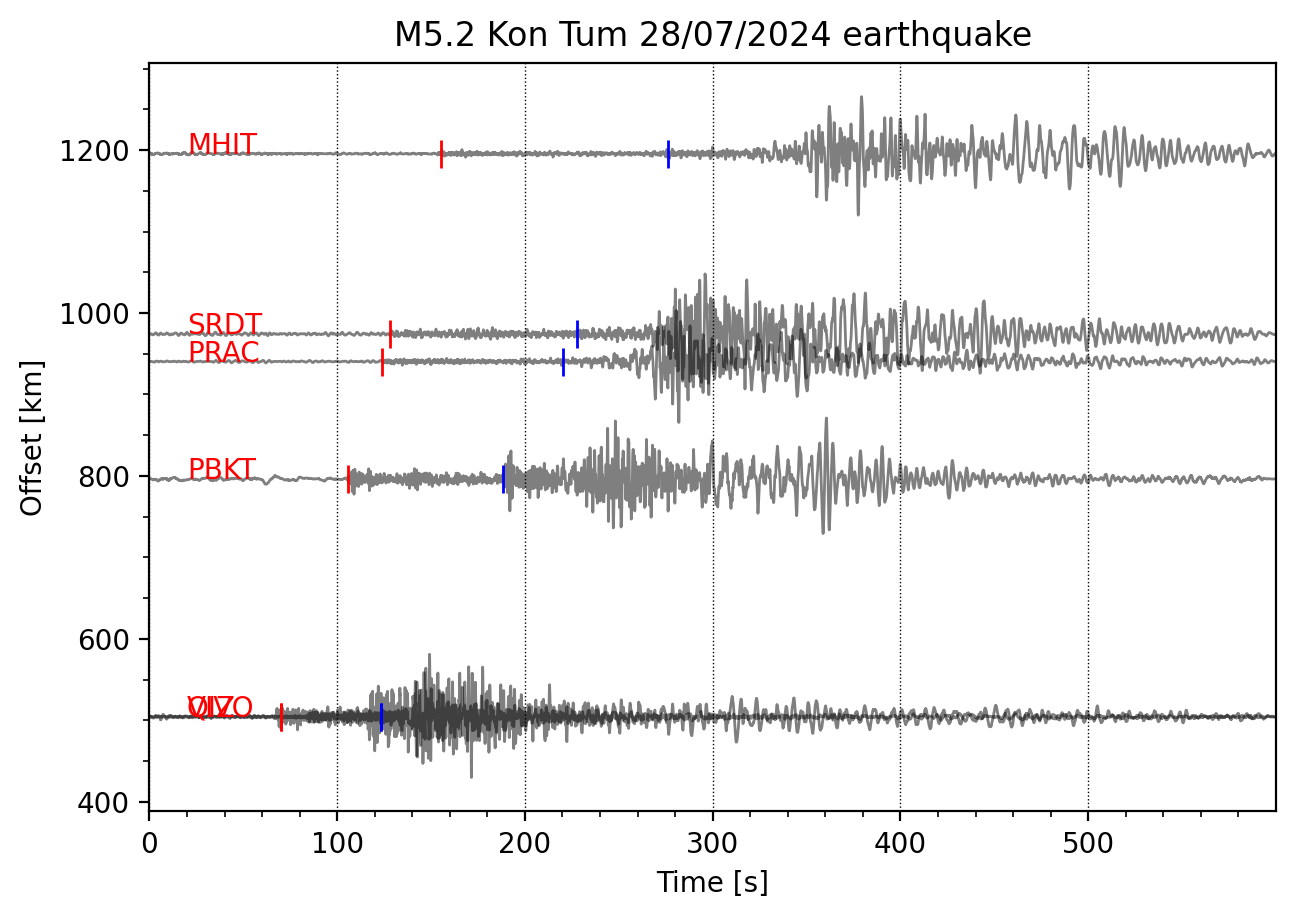

In [10]:
## Calculate individual traces' signal to noise ratio
for tr in dstream.select(component='Z'):
    tvec = tr.times()
    # calculate the noise level
    noise = np.std(tr.data[tvec < 60])
    # calculate the signal level
    signal = np.std(tr.data[np.logical_and(tr.stats.p_arrival<=tvec, tvec<tr.stats.s_arrival+60)])
    # calculate the SNR
    tr.stats.snr = signal / noise
dstream_good = Stream([tr for tr in dstream.select(component='Z') if tr.stats.snr > 2])

## plot stream waveform data using the build-in plotting function
fig = plt.figure()
dstream_good.plot(type='section', orientation='horizontal', norm_method='stream', fig=fig)

## annotate the plot with station names
ax = fig.gca()
ax.set_title('M5.2 Kon Tum 28/07/2024 earthquake')
for tr in dstream_good:
    dist_in_km = tr.stats.distance / 1e3
    ax.text(20, dist_in_km, tr.stats.station, color='r')
    # plot the predicted arrival time of P-wave
    arvs = taup_model.get_travel_times(0, dist_in_km/111.1195, phase_list=['P'])
    ax.plot(arvs[0].time, dist_in_km, '|r', markersize=10, label='P arrival')
    # save arrival to trace stats
    tr.stats.p_arrival = arvs[0].time
    # plot the predicted arrival time of S-wave
    arvs = taup_model.get_travel_times(0, dist_in_km/111.1195, phase_list=['S'])
    ax.plot(arvs[0].time, dist_in_km, '|b', markersize=10, label='S arrival')
    # save arrival to trace stats
    tr.stats.s_arrival = arvs[0].time
plt.show()

---
## Arrival time picking

Now, we learn how to infer the source location by observing the seismic waveforms. The P and S wave arrival time were manually picked subjected to temopral resolution errors. The travel time picks will later be used to triangulate the event location.

In [11]:
#@title Function to plot the waveforms for a given station with arrival times
def plot_waveforms(station):
    import matplotlib.dates as mdates
    fig = plt.figure()
    ## select the trace for the given station and plot them
    st = dstream.select(station=station)
    st.plot(fig=fig, starttime=origin_time, endtime=origin_time + 300)
    ## mark the P and S arrival times
    for ax in fig.axes:
        # P wave arrival
        p_arr = pick_data[station]['p_arr']
        ax.axvline(p_arr, color='r', linestyle='--', linewidth=1)
        ax.text(p_arr, .3, 'P', color='r', fontsize=12)
        # S wave arrival
        s_arr = pick_data[station]['s_arr']
        ax.axvline(s_arr, color='b', linestyle='--', linewidth=1)
        ax.text(s_arr, .3, 'S', color='b', fontsize=12)
    fig.axes[0].xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
    fig.tight_layout()
    plt.show()

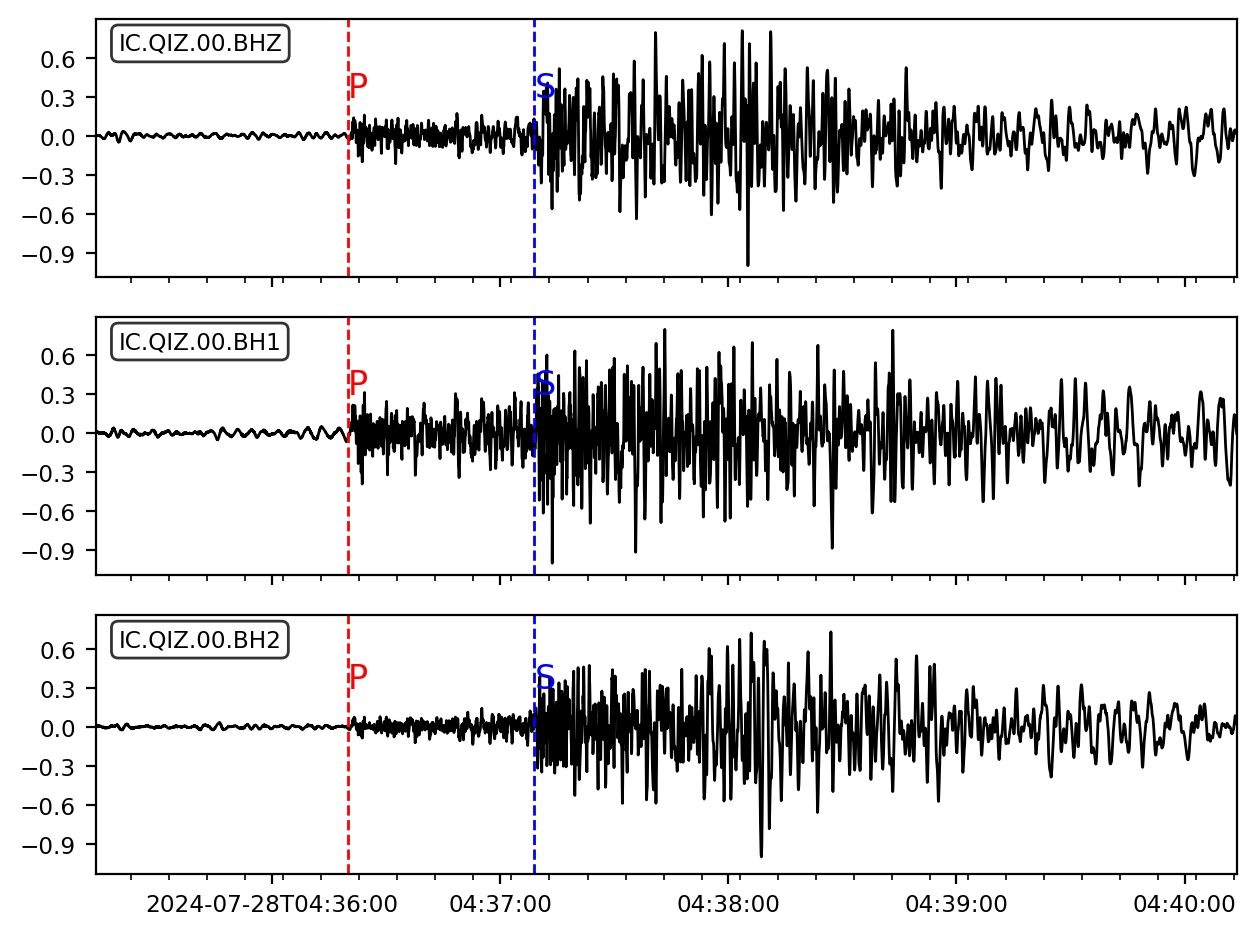

In [12]:
#@title Manually pick the P and S wave arrival times at station VIVO.
from datetime import datetime
pick_data = {}
pick_data['QIZ'] = dict(
    p_arr = datetime(2024,7,28,4,36,20),
    s_arr = datetime(2024,7,28,4,37,9))
plot_waveforms('QIZ')

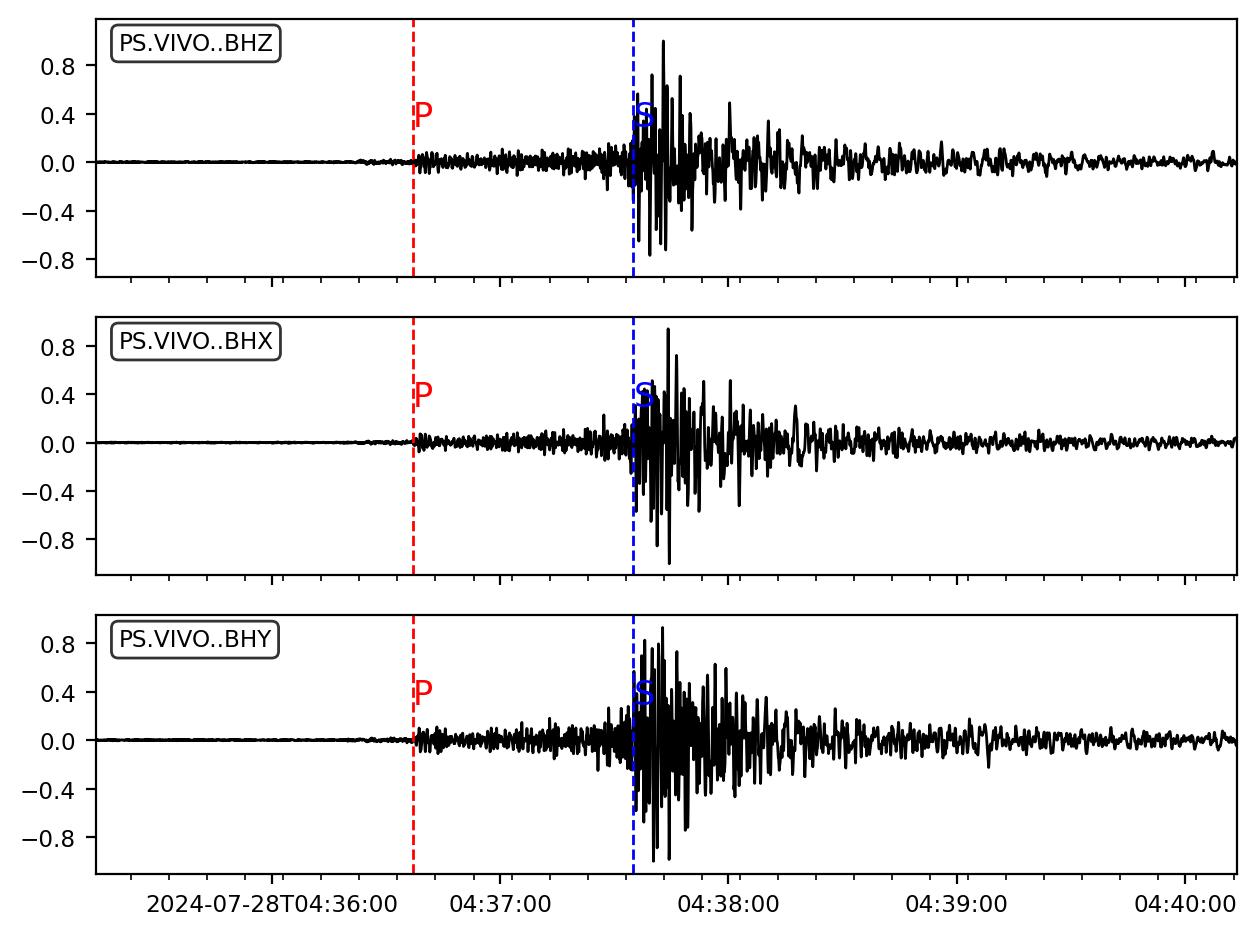

In [13]:
#@title Manually pick the P and S wave arrival times at station VIVO
pick_data['VIVO'] = dict(
    p_arr = datetime(2024,7,28,4,36,37),
    s_arr = datetime(2024,7,28,4,37,35))
plot_waveforms('VIVO')

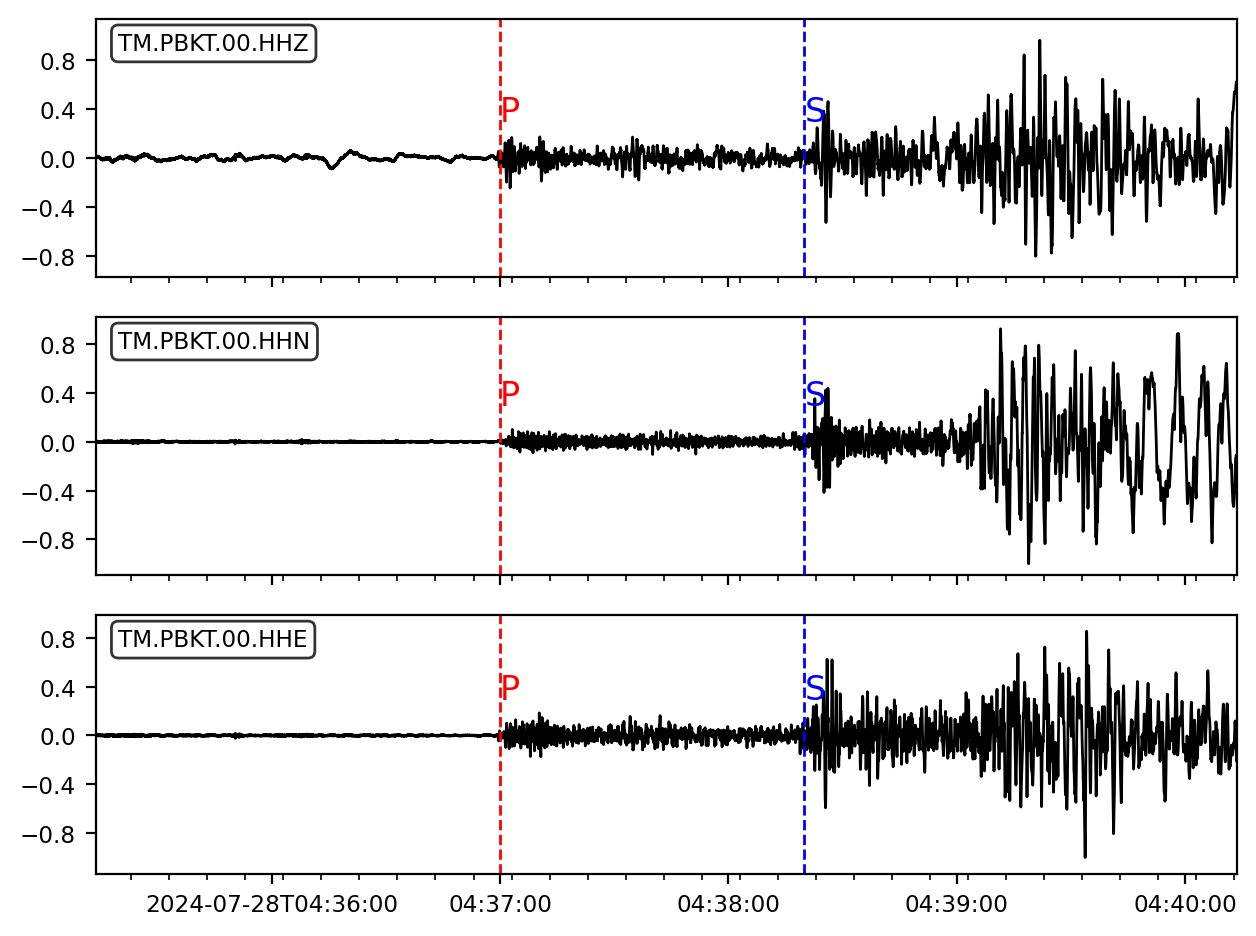

In [14]:
#@title Manually pick the P and S wave arrival times at station PBKT
pick_data['PBKT'] = dict(
    p_arr = datetime(2024,7,28,4,37,0),
    s_arr = datetime(2024,7,28,4,38,20))
plot_waveforms('PBKT')

---
## P- and S-wave travel time curves

Construct the S- to P- differential travel time curves and convert the observed difference to distance (in kms) for each station in the list.

In [15]:
## build the travel time curve for the P and S waves
dist = np.arange(0, 1800, 50)
time_p = np.zeros_like(dist)
time_s = np.zeros_like(dist)
for i, d in enumerate(dist):
    arvs = taup_model.get_travel_times(source_depth_in_km=0, distance_in_degree = d/111.1195, phase_list=['P'])
    time_p[i] = arvs[0].time
    arvs = taup_model.get_travel_times(source_depth_in_km=0, distance_in_degree = d/111.1195, phase_list=['S'])
    time_s[i] = arvs[0].time

for station in pick_data.keys():
    ## time difference to distance conversion
    tdiff = UTCDateTime(pick_data[station]['s_arr']) - UTCDateTime(pick_data[station]['p_arr'])
    pick_data[station]['dist'] = np.interp(tdiff, time_s - time_p, dist)
    ## update the pick_data dictionary with the station coordinates
    pick_data[station]['lon'] = inv.select(station=station)[0][0].longitude
    pick_data[station]['lat'] = inv.select(station=station)[0][0].latitude

---
## Earthquake triangulation

At each station, we draw the circle with radius equal to the estimated distance. The intersection of three circles roughly determine the earthquake hypocenter.

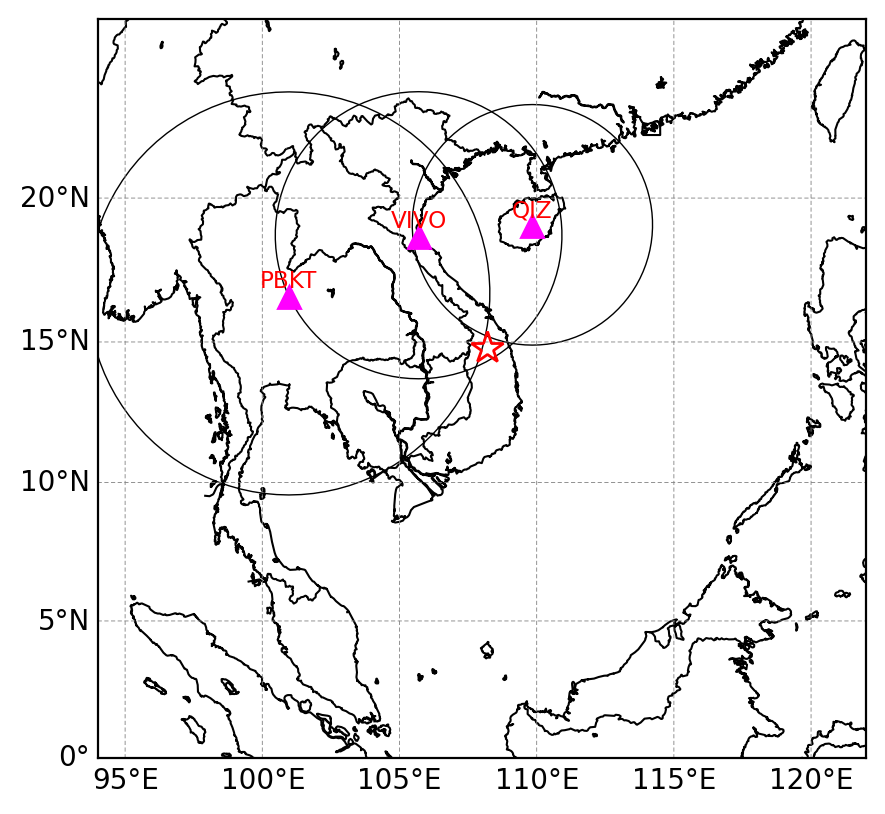

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# create a new figure and axis
fig, ax = plt.subplots()
# initialize the basemap, specifing the projection, the gegraphic buondary, and resolution
# the initialzed map instance is attached to the axis ax
m = Basemap(projection='merc',ax=ax, llcrnrlat=0, urcrnrlat=26,
            llcrnrlon=94, urcrnrlon=122, resolution='i')
# draw coastlines
m.drawcoastlines(linewidth=0.75)
# draw country boundaries
m.drawcountries(linewidth=0.75)
# draw parallels and meridians
m.drawparallels(range(0, 25, 5), labels=[1,0,0,0], linewidth=0.3, color='gray', dashes=(5, 3))
m.drawmeridians(range(90, 125, 5), labels=[0,0,0,1], linewidth=0.3, color='gray', dashes=(5, 3))

# plot the station locations
for key, val in pick_data.items():
    m.plot(val['lon'], val['lat'], '^', c='magenta', markersize=8, latlon=True)
    m.tissot(val['lon'], val['lat'], val['dist']/111.1195, 100, facecolor='none', edgecolor='k', linewidth=0.5)
    x, y = m(val['lon'], val['lat'])
    ax.text(x, y+4e4, key, fontsize='small', color='r', ha='center')
    pick_data[key].update({'x': x, 'y': y})

# plot the epicenter
m.plot(origin_lon, origin_lat, '*', markersize=12, label='Epicenter', latlon=True, c='none', mec='r')

# show the plot
plt.show()

Here we use our customized script to triangulate the Kon Tum earthquake hypocenter. This IRIS [webapp](https://www.iris.edu/hq/inclass/software-web-app/earthquake_triangulation) has similar functionality. You need to provide the station coordinates, and estimated distances (from S- to P-travel time differences).

Why not you try it out if you have finished early?

---
## Remarks

- Earthquake triangulation is one the classical task in seismology, which was done with paper and pen over printed seismograms and maps by early seismologist.

- This exercise hopefully give you some initial senses about dealing with real seismic data.

---
## Bonus project

Hello, thank you for being interested in the bonus project. Although everyone is encouraged to complete bonus projects, undergrad students will be considered for bonus points to their final exams. Best of luck!

*In this project, you are asked to modify the cells to pick arrivals time of at least three stations recording the M7.7 Myanmar 28/03/2025 earthquake, [643071319](https://isc.ac.uk/cgi-bin/web-db-run?event_id=643071319&out_format=ISF2&request=COMPREHENSIVE), and triangulate it either with the customized or IRIS webapp tool.*

If you submit a working code towards completing the task, you will get 50% points. If the code produces correct outcome, you will get 75%. The minimal two-paragraphs on the motivation and additional thoughts will get you to 100%.

Please submit this jupyter notebook to the following form: https://forms.gle/L5QLLYMEnm277bTMA.

In [17]:
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import numpy as np

client = Client("IRIS")


In [18]:
# Thông tin trận động đất ngày 28/03/2025 (theo ISC)
eq_time = UTCDateTime("2025-03-28T10:55:00")  # Giờ gốc (có thể cần điều chỉnh theo catalog)
eq_lat = 22.5  # Vĩ độ Myanmar
eq_lon = 94.0  # Kinh độ Myanmar


In [19]:
# Lấy danh sách trạm trong bán kính 30 độ từ tâm chấn
inventory = client.get_stations(latitude=eq_lat, longitude=eq_lon,
                                maxradius=30, level="station")

# Hiển thị tên các trạm
for net in inventory:
    for sta in net:
        print(f"{net.code}.{sta.code}: {sta.latitude}, {sta.longitude}")


1A.NE36: 43.382999, 120.045998
1A.NE37: 43.490002, 119.901001
1A.NE38: 43.596001, 119.755997
1A.NE39: 43.702, 119.609001
1A.NE40: 43.808998, 119.462997
1A.NE41: 43.915001, 119.315002
1A.NE42: 44.02, 119.167999
1A.NE43: 44.125999, 119.018997
1A.NE44: 44.230999, 118.871002
1A.NE45: 44.337002, 118.721001
1A.NE46: 44.442001, 118.570999
1A.NE47: 44.546001, 118.420998
1A.NE48: 44.651001, 118.269997
1A.NE49: 44.755001, 118.117996
1A.NE50: 44.860001, 117.966003
1A.NE51: 44.964001, 117.814003
1A.NE52: 45.067001, 117.661003
1A.NE53: 45.171001, 117.507004
1A.NE54: 45.273998, 117.352997
1A.NE55: 45.377998, 117.197998
1A.NE56: 45.480999, 117.042
1A.NE57: 45.583, 116.886002
1A.NE58: 45.686001, 116.730003
1A.NE59: 45.787998, 116.572998
1A.NE60: 45.889999, 116.415001
1F.N103: 24.55238, 121.47229
1F.N105: 24.465769, 121.401512
1F.N106: 24.424931, 121.369293
1F.N107: 24.393827, 121.357208
1F.N108: 24.360895, 121.331764
1F.N109: 24.340162, 121.312576
1F.N110: 24.302477, 121.281181
1F.N111: 24.290497, 121

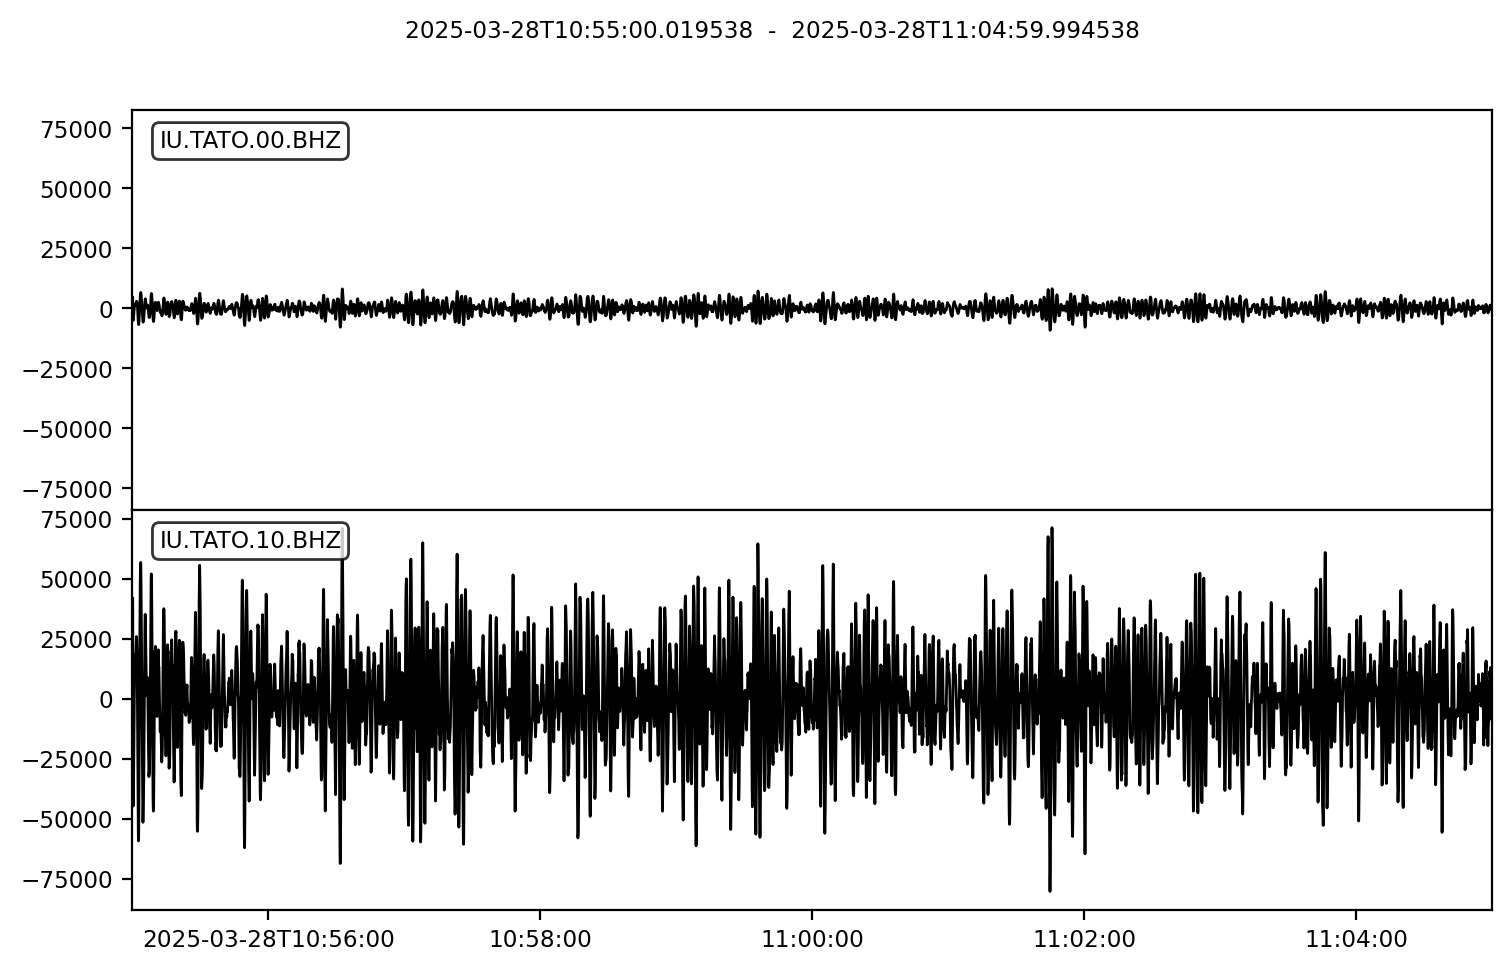

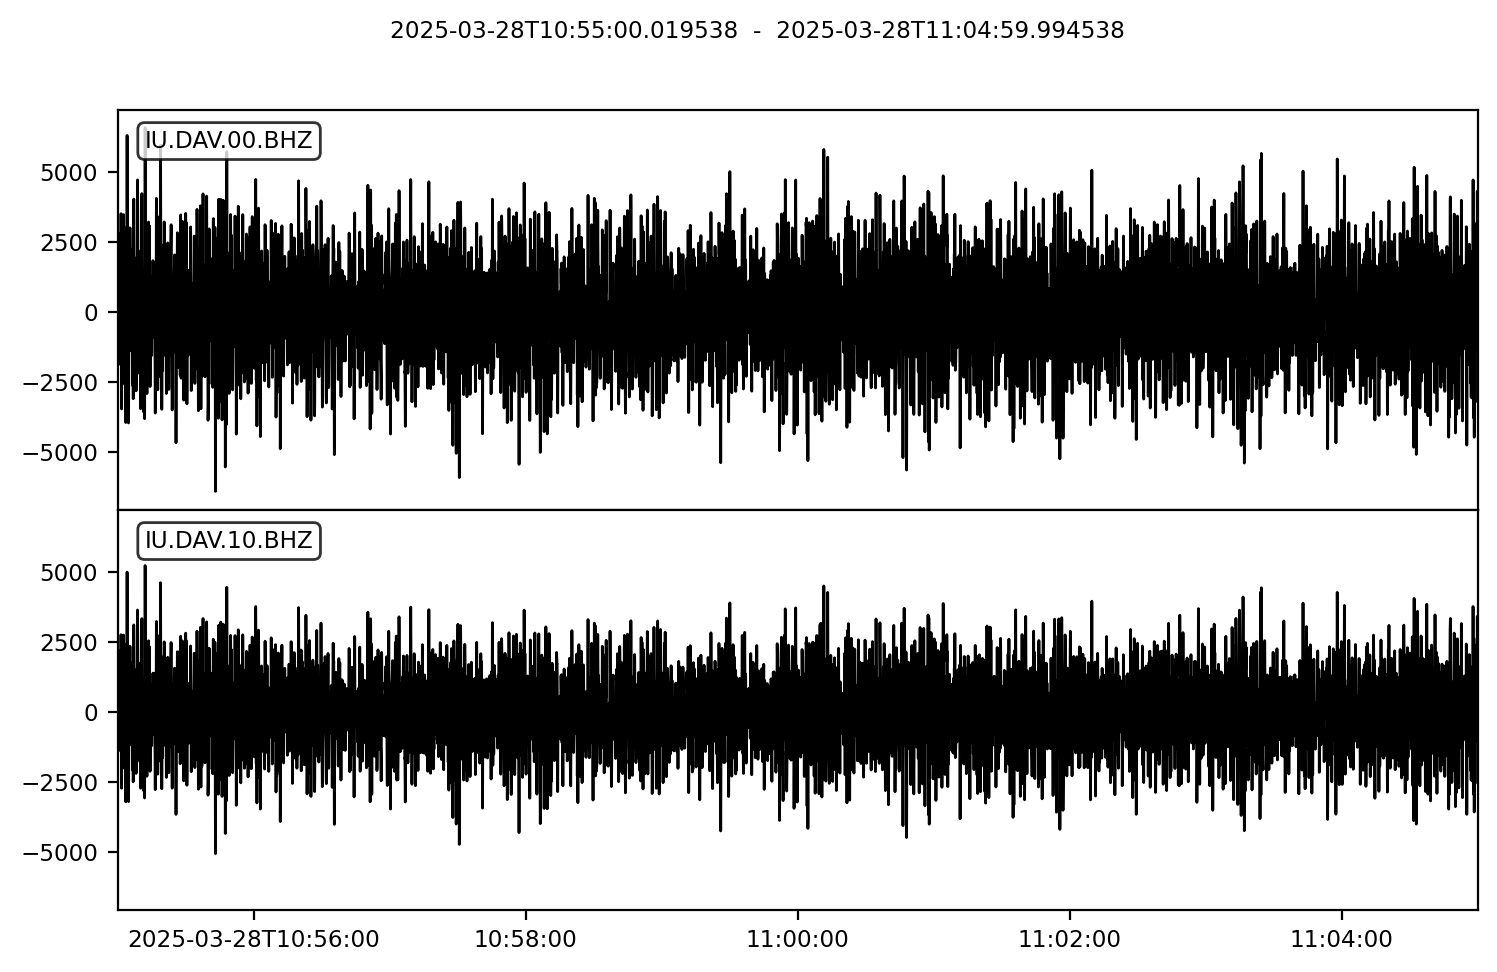

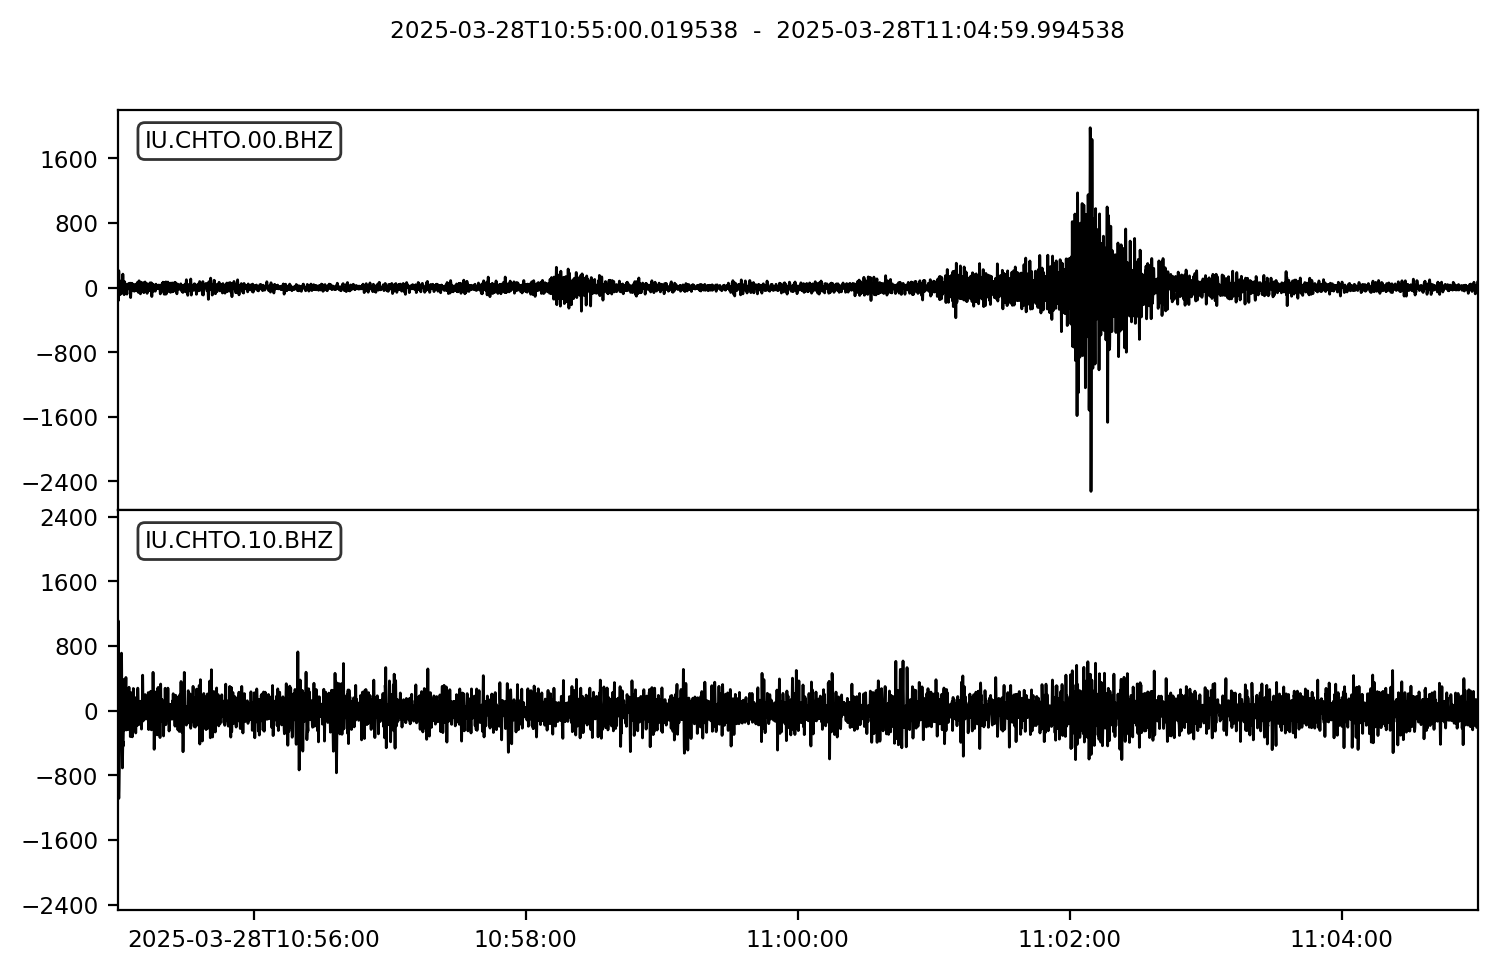

In [20]:
# @title Văn bản tiêu đề mặc định
stations = [
    {"network": "IU", "station": "TATO", "lat": 24.9, "lon": 121.1},
    {"network": "IU", "station": "DAV", "lat": 7.0, "lon": 125.4},
    {"network": "IU", "station": "CHTO", "lat": 18.3, "lon": 98.9}
]

arrivals = []

for sta in stations:
    st = client.get_waveforms(sta["network"], sta["station"], "*", "BHZ",
                              starttime=eq_time, endtime=eq_time + 600)
    st.detrend('demean')
    st.filter('bandpass', freqmin=0.5, freqmax=3)
    st.plot()

    # Quan sát đồ thị và nhập thời điểm sóng P đến (arrival)
    arrival_time = UTCDateTime(input(f"Nhập thời gian đến P-wave tại {sta['station']} (ISO format): "))
    arrivals.append({"lat": sta["lat"], "lon": sta["lon"], "arrival": arrival_time})


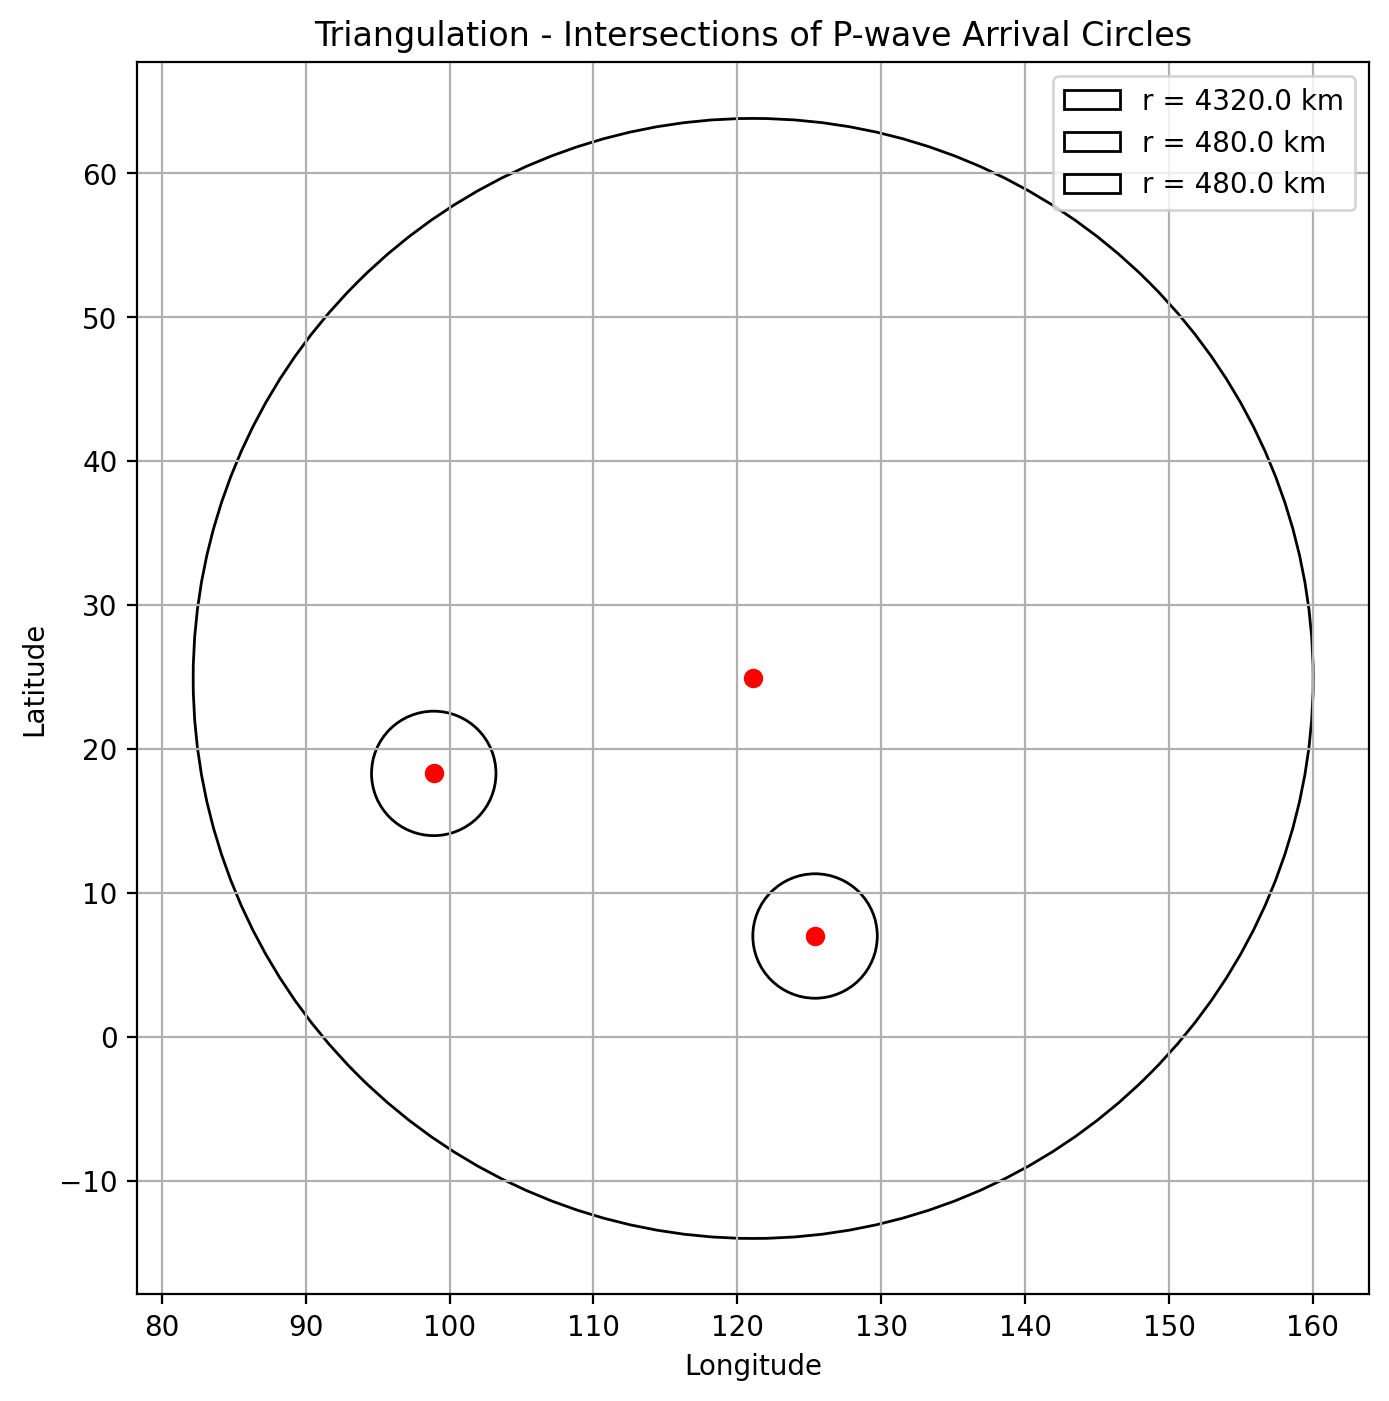

In [21]:
# Tính khoảng cách sóng đi theo arrival time (giả sử vận tốc sóng P = 8 km/s)
velocity = 8.0  # km/s

circles = []
for a in arrivals:
    dt = a["arrival"] - eq_time
    distance_km = dt * velocity
    circles.append((a["lat"], a["lon"], distance_km))

# Vẽ vòng tròn
fig, ax = plt.subplots(figsize=(8, 8))
for lat, lon, r in circles:
    circle = plt.Circle((lon, lat), r / 111, fill=False, label=f"r = {r:.1f} km")
    ax.add_patch(circle)
    ax.plot(lon, lat, 'ro')

ax.set_title("Triangulation - Intersections of P-wave Arrival Circles")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
plt.legend()
plt.grid(True)
plt.show()
